In [1]:
import os
import math
import random
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

os.environ['CUDA_VISIBLE_DEVICES'] = '4'

../../labelling\00000001_0.jpg
../../labelling\00000001_0.xml
68.0 309.0 349.0 434.0


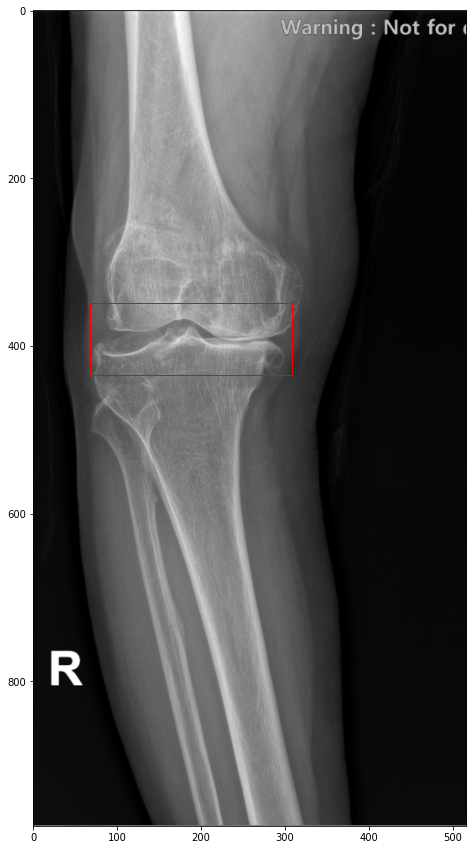

In [2]:
#원본 데이터 1장 확인용 코드(모델에 직접적인 영향은 없는 코드)

from glob import glob
import cv2
import xml.etree.ElementTree as et   
from matplotlib.patches import Rectangle 

image_dir = '../../labelling/'
bbox_dir = '../../labelling/'

image_files = (glob(image_dir + '*.jpg'))
bbox_files = (glob(bbox_dir + "*.xml"))

# len(image_files)
# len(bbox_files)

test = 0

image_path = image_files[test] 
bbox_path = bbox_files[test]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image_path)
print(bbox_path)
tree = et.parse(bbox_path)

xmin = float(tree.find('./object/bndbox/xmin').text)
xmax = float(tree.find('./object/bndbox/xmax').text)
ymin = float(tree.find('./object/bndbox/ymin').text)
ymax = float(tree.find('./object/bndbox/ymax').text)

print(xmin, xmax, ymin, ymax)

rect_x = xmin
rect_y = ymin
rect_w = xmax - xmin
rect_h = ymax - ymin

rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
plt.figure(figsize=(15, 15))
plt.axes().add_patch(rect)
plt.imshow(image)
plt.show()

In [7]:
# 데이터 로더 구현부 (강사님 코드와 많이 유사해서 보시기엔 편하실것 같습니다.)

import pandas as pd
import numpy as np
import cv2
from glob import glob
import xml.etree.ElementTree as et
from tensorflow import keras
from matplotlib.patches import Rectangle

csv_path = './data/grade/KL_grade_kfold_FINAL.csv'
df = pd.read_csv(csv_path)
idx = random.choice(range(len(df)))

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path,
                 fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
            
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
        
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['File_name_pic']
            bbox_name = file_name.replace('.jpg', '.xml')

            image = cv2.imread(f'../../labelling/{file_name}')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # 이미지 빨간박스 그린곳 만큼 자르기
            tree = et.parse(f'../../labelling/{bbox_name}')

            xmin = float(tree.find('./object/bndbox/xmin').text)
            xmax = float(tree.find('./object/bndbox/xmax').text)
            ymin = float(tree.find('./object/bndbox/ymin').text)
            ymax = float(tree.find('./object/bndbox/ymax').text)

            image = image[int(ymin):int(ymax), int(xmin):int(xmax)].copy()
            # ---------------------------------------
            # 즉, bbox로 자른 부분만 데이터 학습에 들어감
            image = cv2.resize(image, (self.image_size, self.image_size))      
            image = image / 255.
            
            label = int(r['KL_Grade'])
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y


In [8]:
#데이터 로더 선언 및 구현부
train_generator = DataGenerator(
    batch_size = 50,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 50,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'val',
    shuffle = True
)

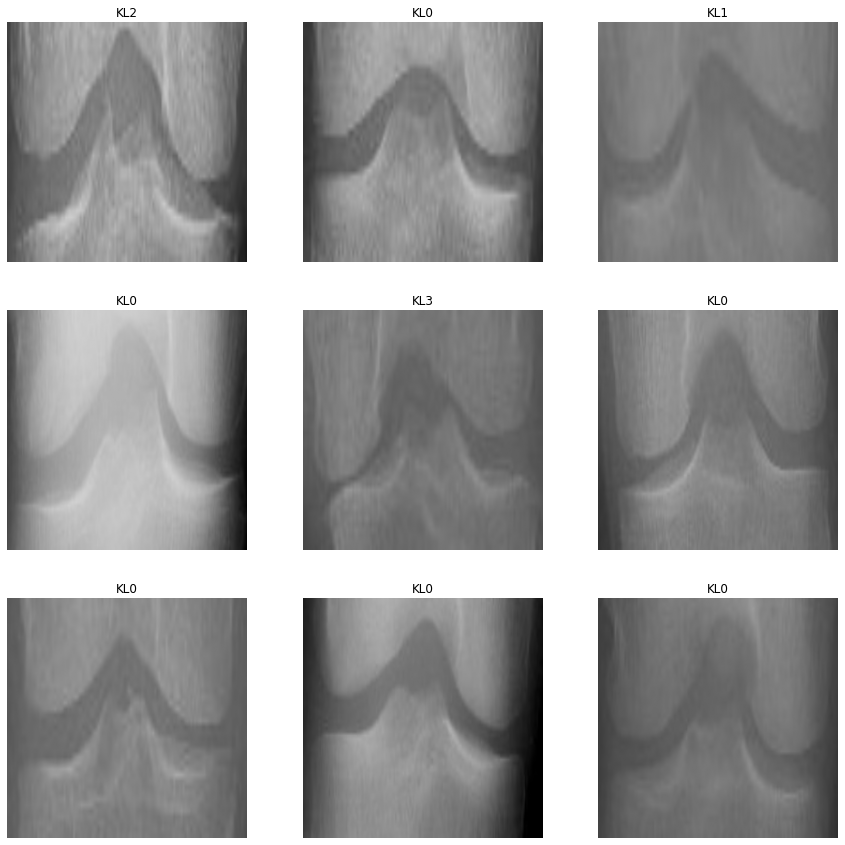

In [33]:
# 학습에 들어가는 data 확인용 코드 (모델에 직접적인 영향은 없는 코드)
# 자른 부분만 학습에 들어감
KL_name = ['KL0', 'KL1', 'KL2', 'KL3', 'KL4']

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(KL_name[y[i]])
        plt.axis('off')
    break

In [24]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras import layers

# VGG14 코드

def get_sequential_model(input_shape):
    model = keras.Sequential(
        [
            # input
            layers.Input(input_shape),
            
            # 1st 
            # 64개의 필터 / 3x3 사이즈 필터 크기 / strides : (위로 1, 아래로 1씩 움직인다.) / padding = same 기존의 크기와 동일하게 만들어준다. /
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same', name ='Conv_layer1-1'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same', name ='Conv_layer1-2'),
            layers.MaxPool2D(name='Pooling_1'),
            
            # 2nd
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same', name ='Conv_layer2-1'),
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same', name ='Conv_layer2-2'),
            layers.MaxPool2D(name='Pooling_2'),

            
            #3 rd
            layers.Conv2D(256, 3, strides=1, activation='relu', padding='same', name ='Conv_layer3-1'),
            layers.Conv2D(256, 3, strides=1, activation='relu', padding='same', name ='Conv_layer3-2'),
            layers.Conv2D(256, 3, strides=1, activation='relu', padding='same', name ='Conv_layer3-3'),
            layers.MaxPool2D(name='Pooling_3'),
            
            # 4th
            layers.Conv2D(512, 3, strides=1, activation='relu', padding='same', name ='Conv_layer4-1'),
            layers.Conv2D(512, 3, strides=1, activation='relu', padding='same', name ='Conv_layer4-2'),
            layers.Conv2D(512, 3, strides=1, activation='relu', padding='same', name ='Conv_layer4-3'),
            layers.MaxPool2D(name='Pooling_4'),
            
            # 5th
            layers.Conv2D(512, 3, strides=1, activation='relu', padding='same', name ='Conv_layer5-1'),
            layers.Conv2D(512, 3, strides=1, activation='relu', padding='same', name ='Conv_layer5-2'),
            layers.Conv2D(512, 3, strides=1, activation='relu', padding='same', name ='Conv_layer5-3'),
            layers.MaxPool2D(name='Pooling_5'),
            layers.BatchNormalization(name = 'Batch_Norm_5'),
            layers.Dropout(0.2),
            
            
            
            layers.Flatten(),
            # Classifier
            #layers.GlobalMaxPool2D(),
            layers.Dense(4096, activation='relu'),
            layers.Dense(4096, activation='relu'),
            layers.Dense(5, activation='softmax')
        ]
    )
    
    return model

In [30]:
# VGG 14를 차용한 코드

def get_sequential_model(input_shape):
    model = keras.Sequential(
        [
            # input
            layers.Input(input_shape),
            
            # 1st 
            # 64개의 필터 / 3x3 사이즈 필터 크기 / strides : (위로 1, 아래로 1씩 움직인다.) / padding = same 기존의 크기와 동일하게 만들어준다. /
            layers.Conv2D(32, 3, strides=1, activation='relu', padding='same', name ='Conv_layer1-1'),
            layers.Conv2D(32, 3, strides=1, activation='relu', padding='same', name ='Conv_layer1-2'),
            layers.MaxPool2D(name='Pooling_1'),
            layers.BatchNormalization(name = 'Batch_Norm_1'),
            layers.Dropout(0.2),
            
            # 2nd
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same', name ='Conv_layer2-1'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same', name ='Conv_layer2-2'),
            layers.MaxPool2D(name='Pooling_2'),
            layers.BatchNormalization(name = 'Batch_Norm_2'),
            layers.Dropout(0.2),
            
            #3 rd
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same', name ='Conv_layer3-1'),
            layers.MaxPool2D(name='Pooling_3'),
            layers.BatchNormalization(name = 'Batch_Norm_3'),
            layers.Dropout(0.2),
            
            # 4th
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same', name ='Conv_layer4-1'),
            layers.MaxPool2D(name='Pooling_4'),
            layers.BatchNormalization(name = 'Batch_Norm_4'),
            layers.Dropout(0.2),
            
            # 5th
            layers.Conv2D(256, 3, strides=1, activation='relu', padding='same', name ='Conv_layer5-1'),
            layers.MaxPool2D(name='Pooling_5'),
            layers.BatchNormalization(name = 'Batch_Norm_5'),
            layers.Dropout(0.2),
            
            # Classifier
            
            # layers.Flatten(input_shape= input_shape),            
            layers.GlobalMaxPool2D(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(5, activation='softmax')  #grade(0~4 까지 출력해줘야 하므로 출력은 Dense 5 설정)
        ]
    )
    
    return model

In [31]:
input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

In [32]:
# 모델 컴파일 및 summary
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_layer1-1 (Conv2D)       (None, 256, 256, 32)      896       
_________________________________________________________________
Conv_layer1-2 (Conv2D)       (None, 256, 256, 32)      9248      
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 128, 128, 32)      0         
_________________________________________________________________
Batch_Norm_1 (BatchNormaliza (None, 128, 128, 32)      128       
_________________________________________________________________
dropout_14 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
Conv_layer2-1 (Conv2D)       (None, 128, 128, 64)      18496     
_________________________________________________________________
Conv_layer2-2 (Conv2D)       (None, 128, 128, 64)     

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    verbose=1
)